# Audio Chunking
### Ferry Source Data
Last Modified Juy 9, 2019

In [60]:
from __future__ import print_function
import matplotlib
#from IPython.core.interactiveshell import InteractiveShell
#InteractiveShell.ast_node_interactivity = "all"
import matplotlib.pyplot as plt
from IPython.display import Markdown, display
from IPython.display import SVG
import scipy.io.wavfile as wavfile
import pandas as pd
import numpy as np
import os
import crepe
import sklearn
from scipy.io import wavfile
from sklearn import preprocessing
import pickle
np.set_printoptions(suppress=True)
import librosa
import resampy
from os import listdir
import os.path
from os.path import isfile, join
import pandas as pd
import seaborn as sns
import pandas as pd

In [61]:
#Define folder paths
cwd = "D:\\"
root = os.path.join(cwd, "Ferry","original-source")
os.chdir(root)
os.getcwd()

'D:\\Ferry\\original-source'

### Ingest, Resample and Slice Audio Data

In [62]:
resample_rate = 32000
for subdir, dirs, files in os.walk(root):
    for file in files:
        filepath = subdir + os.sep + file
        if filepath.endswith(".wav"):
            fs, data = wavfile.read(filepath)
            y = resampy.resample(data, fs, resample_rate)
            wavfile.write(filepath, resample_rate, y)
            

In [63]:
#Define folder paths
cwd = "D:\\"
tacoma = os.path.join(cwd, "Ferry","original-source","tacoma")
wenatchee = os.path.join(cwd, "Ferry","original-source","wenatchee")

tacoma_1sec = os.path.join(cwd, "Ferry","1_sec_chunks","tacoma")
wenatchee_1sec = os.path.join(cwd, "Ferry","1_sec_chunks","wenatchee")

os.chdir(tacoma)
os.getcwd()

'D:\\Ferry\\original-source\\tacoma'

### Slice Audio to Desired Lengths

In [66]:
def _slice_audio_data(raw_audio_data, interval_len=1):
    accounted_fs = int(32000 * interval_len)
    num_slices = int(len(raw_audio_data) / accounted_fs)
    audio_data = raw_audio_data[: int(num_slices * accounted_fs)]  # Trims audio array
    sliced_audio = np.split(audio_data, num_slices)
    return np.array(sliced_audio)

In [7]:
os.chdir(tacoma)
for subdir, dirs, files in os.walk(tacoma):
    for file in files:
        filepath = subdir + os.sep + file
        if filepath.endswith(".wav"):
            fs, data = wavfile.read(filepath)
            sliced_audio = _slice_audio_data(data, 1)
            sliced_audio = sliced_audio[0:60,:]
            print(sliced_audio.shape)
            os.chdir(tacoma_1sec)
            for i in range(sliced_audio.shape[0]):
                num = str(i)
                wavfile.write(num+file, resample_rate, sliced_audio[i,:])
filepath = ""  
os.chdir(wenatchee)
for subdir, dirs, files in os.walk(wenatchee):
    for file in files:
        filepath = subdir + os.sep + file
        if filepath.endswith(".wav"):
            fs, data = wavfile.read(filepath)
            sliced_audio = _slice_audio_data(data, 1)
            sliced_audio = sliced_audio[0:60,:]
            print(sliced_audio.shape)
            os.chdir(wenatchee_1sec)
            for i in range(sliced_audio.shape[0]):
                num = str(i)
                wavfile.write(num+file, resample_rate, sliced_audio[i,:])

(60, 32000)
(60, 32000)
(60, 32000)
(60, 32000)
(60, 32000)
(60, 32000)
(60, 32000)


In [67]:
#Define folder paths
cwd = "D:\\"
tacoma_1sec_train = os.path.join(cwd, "Ferry","1_sec_chunks","tacoma","tacoma_train")
tacoma_1sec_test = os.path.join(cwd, "Ferry","1_sec_chunks","tacoma","tacoma_test")

wenatchee_1sec_train = os.path.join(cwd, "Ferry","1_sec_chunks","wenatchee","wenatchee_train")
wenatchee_1sec_test = os.path.join(cwd, "Ferry","1_sec_chunks","wenatchee","wenatchee_test")

In [68]:
print(tacoma_1sec_train)
print(tacoma_1sec_test)
print(wenatchee_1sec_train)
print(wenatchee_1sec_test)

D:\Ferry\1_sec_chunks\tacoma\tacoma_train
D:\Ferry\1_sec_chunks\tacoma\tacoma_test
D:\Ferry\1_sec_chunks\wenatchee\wenatchee_train
D:\Ferry\1_sec_chunks\wenatchee\wenatchee_test


In [10]:
for subdir, dirs, files in os.walk(wenatchee_1sec_train):
    total_1_second_wenatchee_train = []
    for file in files:
        filepath = subdir + os.sep + file
        fs, raw_audio = wavfile.read(filepath)
        total_1_second_wenatchee_train.append((raw_audio))
        
for subdir, dirs, files in os.walk(tacoma_1sec_train):
    total_1_second_tacoma_train = []
    for file in files:
        filepath = subdir + os.sep + file
        fs, raw_audio = wavfile.read(filepath)
        total_1_second_tacoma_train.append((raw_audio))

for subdir, dirs, files in os.walk(wenatchee_1sec_test):
    total_1_second_wenatchee_test = []
    for file in files:
        filepath = subdir + os.sep + file
        fs, raw_audio = wavfile.read(filepath)
        total_1_second_wenatchee_test.append((raw_audio))
        
for subdir, dirs, files in os.walk(tacoma_1sec_test):
    total_1_second_tacoma_test = []
    for file in files:
        filepath = subdir + os.sep + file
        fs, raw_audio = wavfile.read(filepath)
        total_1_second_tacoma_test.append((raw_audio))

In [11]:
# Convert from nested list to array
total_1_second_tacoma_train = np.asarray(total_1_second_tacoma_train)
new_1_second_tacoma_train = np.empty((32000), int)

for row in range(31,121,1):
    newrow = total_1_second_tacoma_train[row]
    new_1_second_tacoma_train = np.vstack([new_1_second_tacoma_train, newrow])
       
new_1_second_tacoma_train = np.array(new_1_second_tacoma_train)
new_1_second_tacoma_train.shape

(91, 32000)

In [12]:
# Convert from nested list to array
total_1_second_wenatchee_train = np.asarray(total_1_second_wenatchee_train)
new_1_second_wenatchee_train = np.empty((32000), int)

for row in range(4,94,1):
    newrow = total_1_second_wenatchee_train[row]
    new_1_second_wenatchee_train = np.vstack([new_1_second_wenatchee_train, newrow])
       
new_1_second_wenatchee_train = np.array(new_1_second_wenatchee_train)
new_1_second_wenatchee_train.shape

(91, 32000)

In [13]:
# Convert from nested list to array
total_1_second_tacoma_test = np.asarray(total_1_second_tacoma_test)
new_1_second_tacoma_test = np.empty((32000), int)

for row in range(4,84,1):
    newrow = total_1_second_tacoma_test[row]
    new_1_second_tacoma_test = np.vstack([new_1_second_tacoma_test, newrow])
       
new_1_second_tacoma_test = np.array(new_1_second_tacoma_test)
new_1_second_tacoma_test.shape

(81, 32000)

In [14]:
# Convert from nested list to array
total_1_second_wenatchee_test = np.asarray(total_1_second_wenatchee_test)
new_1_second_wenatchee_test = np.empty((32000), int)

for row in range(4,84,1):
    newrow = total_1_second_wenatchee_test[row]
    new_1_second_wenatchee_test = np.vstack([new_1_second_wenatchee_test, newrow])
       
new_1_second_wenatchee_test = np.array(new_1_second_wenatchee_test)
new_1_second_wenatchee_test.shape

(81, 32000)

### Save Chunked Audio Locally

In [15]:
os.chdir("D:\\ferry")
print(os.getcwd())

np.savetxt('new_1_second_tacoma_train.txt', new_1_second_tacoma_train, delimiter=',')
np.savetxt('new_1_second_wenatchee_train.txt', new_1_second_wenatchee_train, delimiter=',')
np.savetxt('new_1_second_tacoma_test.txt', new_1_second_tacoma_test, delimiter=',')
np.savetxt('new_1_second_wenatchee_test.txt', new_1_second_wenatchee_test, delimiter=',')

D:\ferry


### Inspect Audio

In [16]:
len(new_1_second_wenatchee_train)

new_1_second_wenatchee_train = new_1_second_wenatchee_train.astype(float)
new_1_second_tacoma_train = new_1_second_tacoma_train.astype(float)
new_1_second_wenatchee_test = new_1_second_wenatchee_test.astype(float)
new_1_second_tacoma_test = new_1_second_tacoma_test.astype(float)

In [17]:
D_left_wenatchee_train = np.abs(librosa.core.ifgram(new_1_second_wenatchee_train[50,:], center=False))
D_left_wenatchee_train.shape

(2, 1025, 59)

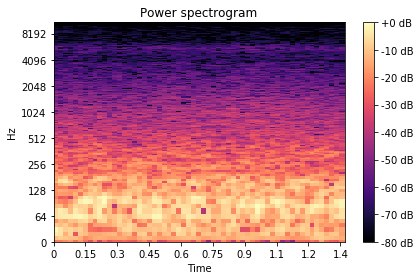

In [18]:
import librosa.display
import matplotlib.pyplot as plt
librosa.display.specshow(librosa.amplitude_to_db(D_left_wenatchee_train[1,:,:], ref=np.max),
                          y_axis='log', x_axis='time')
plt.title('Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()

In [19]:
D_left_tacoma_train = np.abs(librosa.core.ifgram(new_1_second_tacoma_train[50,:], center=False))

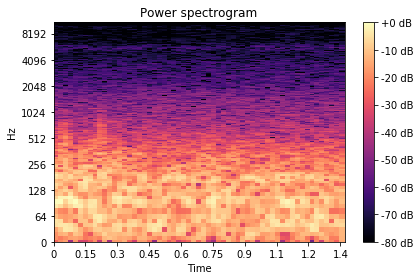

In [20]:
import librosa.display
import matplotlib.pyplot as plt
librosa.display.specshow(librosa.amplitude_to_db(D_left_tacoma_train[1,:,:], ref=np.max),
                          y_axis='log', x_axis='time')
plt.title('Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()

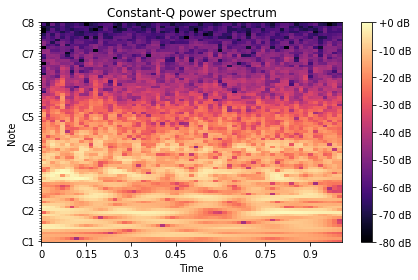

In [22]:

C = np.abs(librosa.cqt(new_1_second_tacoma_train[50,:], sr=32000))
librosa.display.specshow(librosa.amplitude_to_db(C, ref=np.max),
                         sr=32000, x_axis='time', y_axis='cqt_note')
plt.colorbar(format='%+2.0f dB')
plt.title('Constant-Q power spectrum')
plt.tight_layout()